# Chess Data Analysis

by: Abhiram Naredla, Devarsh Shah and Veer Patel

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

df = pd.read_csv("games.csv")
df.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


## Step 1 - Exploratory Data Analysis

In [2]:
# Select relevant columns
df = df[["rated","turns","victory_status","winner","white_rating","black_rating","opening_name"]]
df.head()

,rated,turns,victory_status,winner,white_rating,black_rating,opening_name
0,False,13,outoftime,white,1500,1191,Slav Defense: Exchange Variation
1,True,16,resign,black,1322,1261,Nimzowitsch Defense: Kennedy Variation
2,True,61,mate,white,1496,1500,King's Pawn Game: Leonardis Variation
3,True,61,mate,white,1439,1454,Queen's Pawn Game: Zukertort Variation
4,True,95,mate,white,1523,1469,Philidor Defense


In [3]:
# Clean up the opening_name column to exclude sub-variations of standard chess openings
df['opening_name'].nunique()

1477

Cleaning the "opening_name" column - opening_name column currently has 1477 different variations. We will bring this down by only accounting for the type of opening and not any variations of the opening. For instance: "Slav Defense: Exchange Variation" will just be Slav Defense in our model.

In [4]:
# Clean up the opening_name column to exclude sub-variations of standard chess openings
df['opening_name'] = df['opening_name'].str.split(':').str[0]
df['opening_name'] = df['opening_name'].str.split('#').str[0]
df['opening_name'] = df['opening_name'].str.split('|').str[0]
df['opening_name'].nunique()

169

After data cleaning, the opening_name column has 169 unique values which is much better for our machine learning model.

In [5]:
# Clean the data frame
df = df.dropna()
df = df.drop_duplicates()
df.shape

(19110, 7)

In [6]:
df["rated"].describe()

count     19110
unique        2
top        True
freq      15467
Name: rated, dtype: object

Since majority of the data contains rated chess games (rated = True), let's filter the data to only include these rated games.

In [7]:
df = df[df['rated'] == True]
df = df[["turns","victory_status","winner","white_rating","black_rating","opening_name"]]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15467 entries, 1 to 20057
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   turns           15467 non-null  int64 
 1   victory_status  15467 non-null  object
 2   winner          15467 non-null  object
 3   white_rating    15467 non-null  int64 
 4   black_rating    15467 non-null  int64 
 5   opening_name    15467 non-null  object
dtypes: int64(3), object(3)
memory usage: 845.9+ KB


Dataset now contains 15467 rows, down from 19110. Since all the games are now rated, we don't need the 'rated' column in our data frame anymore.

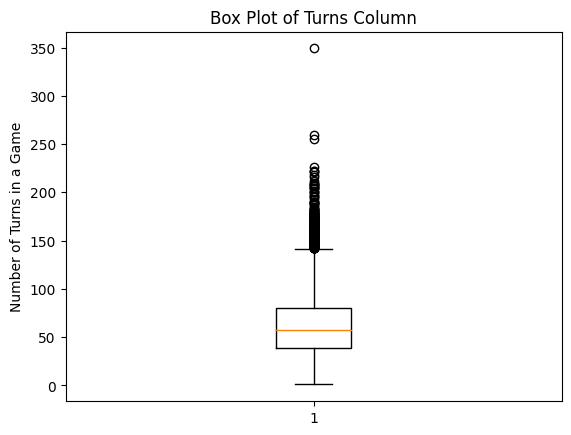

In [8]:
plt.boxplot(df['turns'])

plt.ylabel('Number of Turns in a Game')
plt.title('Box Plot of Turns Column')
plt.show()

In [9]:
df['turns'].describe()

count    15467.000000
mean        61.957005
std         33.649278
min          1.000000
25%         39.000000
50%         57.000000
75%         80.000000
max        349.000000
Name: turns, dtype: float64

Since the turns column has a substantial amount of outliers, we filter the it to get rid of the outliers, using only the data between its 25th and 75th percentile (39 and 80).

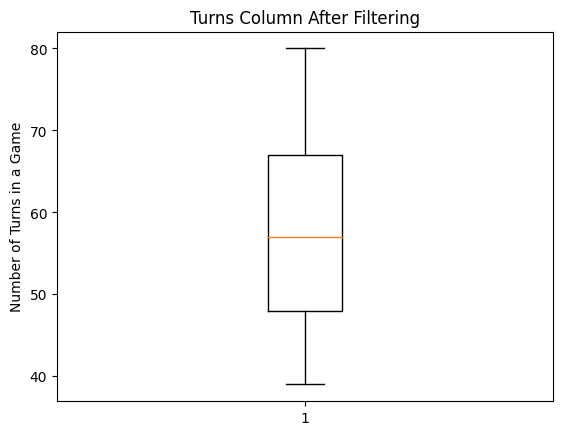

In [10]:
df = df[(df['turns'] >= 39) & (df['turns'] <= 80)]

plt.boxplot(df['turns'])

plt.ylabel('Number of Turns in a Game')
plt.title('Turns Column After Filtering')
plt.show()

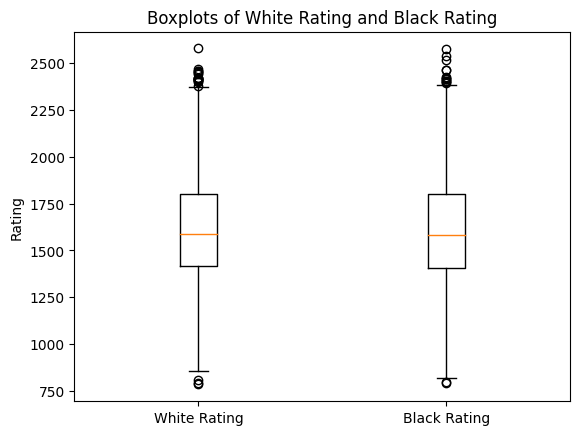

In [11]:
plt.boxplot([df['white_rating'], df['black_rating']], labels=['White Rating', 'Black Rating'])
plt.title('Boxplots of White Rating and Black Rating')
plt.ylabel('Rating')
plt.show()

white rating and black rating columns also have a substantial amount of outliers so we filter these the same way

In [12]:
df["white_rating"].describe()

count    7804.000000
mean     1607.689006
std       280.502181
min       784.000000
25%      1415.000000
50%      1589.000000
75%      1799.000000
max      2579.000000
Name: white_rating, dtype: float64

In [13]:
df["black_rating"].describe()

count    7804.000000
mean     1605.829959
std       283.934761
min       791.000000
25%      1407.000000
50%      1584.000000
75%      1800.000000
max      2577.000000
Name: black_rating, dtype: float64

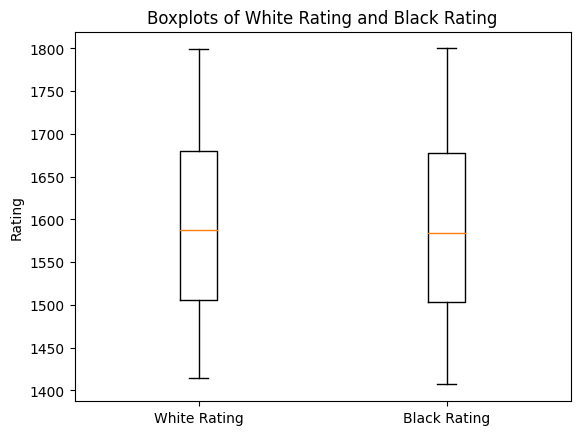

In [14]:
df = df[(df['white_rating'] >= 1415) & (df['white_rating'] <= 1799)]
df = df[(df['black_rating'] >= 1407) & (df['black_rating'] <= 1800)]

plt.boxplot([df['white_rating'], df['black_rating']], labels=['White Rating', 'Black Rating'])
plt.title('Boxplots of White Rating and Black Rating')
plt.ylabel('Rating')
plt.show()

Since our dataset contains 169 unique values for "opening_name", we only account for the 10 most frequent values to maintain the accuracy of our machine learning model.

In [15]:
# Only including the 10 most frequently used openings
top_10_openings = df['opening_name'].value_counts().nlargest(10).index
df = df[df['opening_name'].isin(top_10_openings)]

df['opening_name'].nunique()

10

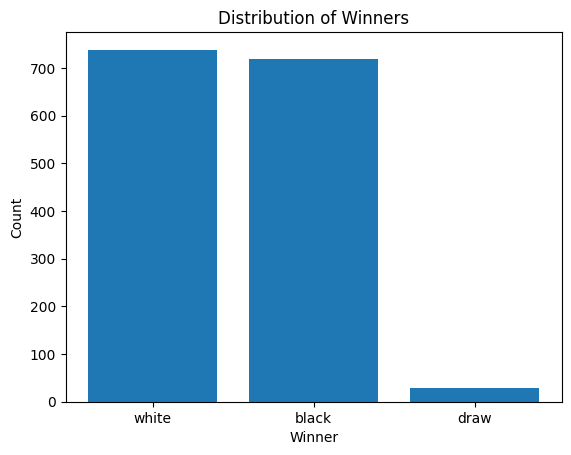

In [16]:
# Plotting the bar graph of the "winner" column
winner_counts = df["winner"].value_counts()

plt.bar(winner_counts.index, winner_counts.values)
plt.xlabel('Winner')
plt.ylabel('Count')
plt.title('Distribution of Winners')
plt.show()

Since our data frame contains few games that are "draw", we exclude these rows altogether.

In [17]:
# Remove draw values
df = df[df['winner'].isin(['white', 'black'])]
df.shape

(1456, 6)

Our final data frame contains 1456 rows and 6 columns.

## Step 2 - Engineering a Machine learning model

We've implemented a machine learning model that takes white rating, black rating, number of turns, and opening name as input variables and predicts the winner of the game - the black or white pieces. Our model is intended to be used by new chess players who are looking to play a new chess opening.

In [18]:
# Split data into train-test split
import numpy as np
from sklearn.model_selection import train_test_split

input_variables = df[["turns","white_rating","black_rating","opening_name"]]
output_variable = df["winner"]
input_variables_encoded = pd.get_dummies(input_variables, columns=['opening_name'], drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(input_variables_encoded, output_variable, test_size=0.1, random_state=33)

We use a 90-10, train-test split to achieve the highest accuracy for our model.

In [19]:
# Now let's define our models
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

lr_classifier = LogisticRegression(solver='lbfgs',max_iter=10000)
mlp_classifier = MLPClassifier(solver='lbfgs', alpha=1e-5,
                               hidden_layer_sizes=(10, 2), random_state=33,max_iter=10000)
knn_classifier = KNeighborsClassifier(n_neighbors=5)
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

In [20]:
lr_classifier.fit(X_train.to_numpy(),y_train.to_numpy())

LogisticRegression(max_iter=10000)

In [21]:
mlp_classifier.fit(X_train.to_numpy(),y_train.to_numpy())

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(10, 2), max_iter=10000,
              random_state=33, solver='lbfgs')

In [22]:
knn_classifier.fit(X_train, y_train)

KNeighborsClassifier()

In [23]:
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [24]:
from sklearn.metrics import accuracy_score

y_predicted_lr = lr_classifier.predict(X_test)
lr_accuracy_score = accuracy_score(y_predicted_lr,y_test)

y_predicted_mlp = mlp_classifier.predict(X_test)
mlp_accuracy_score = accuracy_score(y_predicted_mlp,y_test)

y_pred = knn_classifier.predict(X_test)
knn_accuracy = accuracy_score(y_test, y_pred)

y_predicted_rf = rf_classifier.predict(X_test)
rf_accuracy_score = accuracy_score(y_predicted_rf, y_test)

print(f"Accuracy of the Logistic Classifier = {lr_accuracy_score:.2f}")
print (f"Accuracy of the MLP Classifier = {mlp_accuracy_score:.2f}")
print (f"Accuracy of the k-Nearest Neighbour Classifier = {knn_accuracy:.2f}")
print(f"Accuracy of the Random Forest Classifier = {rf_accuracy_score:.2f}")

Accuracy of the Logistic Classifier = 0.60
Accuracy of the MLP Classifier = 0.49
Accuracy of the k-Nearest Neighbour Classifier = 0.55
Accuracy of the Random Forest Classifier = 0.58


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


## Step 3 - Testing our Model

Our model takes white rating, black rating, number of turns and opening name as input variables and predicts the winner of the game. This model helps new chess players decide which chess opening the should choose to win games.

In [25]:
# Sample input data for testing
turns = 13
white_rating = 1500
black_rating = 1191
opening_name = "Slav Defense"

test_data = pd.DataFrame([[turns, white_rating, black_rating, opening_name]],
                         columns=['turns', 'white_rating', 'black_rating', 'opening_name'])

# One-hot encoding to 'opening_name'
test_data_encoded = pd.get_dummies(test_data, columns=['opening_name'], drop_first=True)

missing_columns = set(input_variables_encoded.columns) - set(test_data_encoded.columns)
for col in missing_columns:
    test_data_encoded[col] = 0

# Use classifier to make predictions
y_predicted_lr = lr_classifier.predict(test_data_encoded)
print(f"Predicted Winner: {y_predicted_lr[0]}")

Predicted Winner: white


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


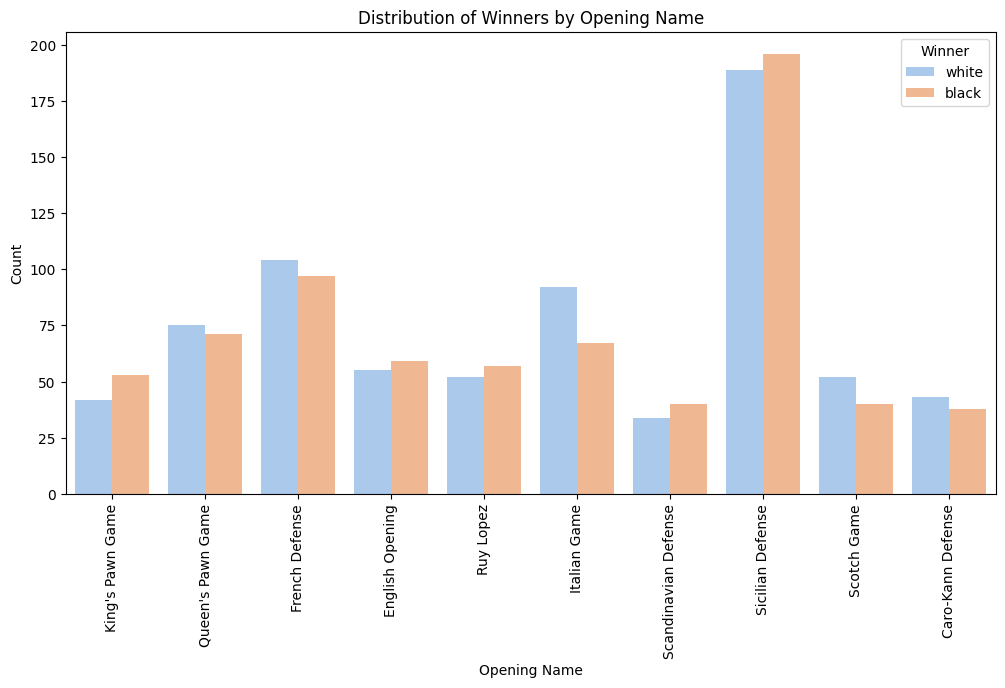

In [26]:
# Plot 1

plt.figure(figsize=(12, 6))
sns.countplot(x='opening_name', hue='winner', data=df, palette='pastel')
plt.title('Distribution of Winners by Opening Name')
plt.xlabel('Opening Name')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend(title='Winner')
plt.show()

This bar chart exhibits the white:black win ratios for each chess opening and allows new chess players to easily choose an opening.